# Manipulate data
In this notebook the reference data and the user data are manipulated

In [ ]:
#Imports
import geopandas as gpd
from shapely import Polygon, MultiPolygon

In [ ]:
from pyproj import Proj, Transformer 
from shapely.ops import transform
from pathlib import Path

## Reference countries
I used the following dataset <br>https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/information/<br> for the country reference shapes. The cells below contain the modification made to the data. 

In [ ]:
ref_gdf = gpd.read_file('./world-administrative-boundaries.geojson')
ref_gdf

### DONE: Remove small islands seperated from the mainland
Some countries, like Chile and Denmark, have a small island that is seperated from the mainland by a large distane. 
Lets remove these "outliers"

In [ ]:
def rm_outlier(geom, min_length=0.8, min_area=0.05):
    if isinstance(geom, Polygon):
        return geom

    #Get current geom boundary length 
    xmin, ymin, xmax, ymax = geom.bounds
    geom_length = (xmax - xmin) + (ymax - ymin)
        
    polygons = [poly for poly in geom.geoms]
    new_polygons = []
    for idx in range(len(polygons)):
        subset = polygons.copy()
        poly = subset.pop(idx)
        new_geom = MultiPolygon(subset)
        xmin, ymin, xmax, ymax = new_geom.bounds
        length = (xmax - xmin) + (ymax - ymin)
        
        #Check if the polygon should be omitted 
        if (length / geom_length) > min_length or (poly.area / geom.area) > min_area:
            new_polygons.append(poly)
    
    return MultiPolygon(new_polygons)

In [ ]:
ref_gdf['geometry'] = ref_gdf['geometry'].apply(rm_outlier)

In [ ]:
ref_gdf.to_file('./reference.geojson')

### DONE: Change map projection
The projection used in the reference dataset seems to be the equirectangular projection. This leads to deformed country shapes, especially around the poles.

In [ ]:
def change_projection(polygon):
    source_proj = Proj(init='EPSG:4326')  # WGS84 geographic coordinate system
    target_proj = Proj(init='EPSG:3857')  # Web Mercator projection
    transformer = Transformer.from_proj(source_proj, target_proj)

    return transform(transformer.transform, polygon)

In [ ]:
ref_gdf['geometry'] = ref_gdf['geometry'].apply(change_projection)

In [ ]:
ref_gdf.to_file('./reference.geojson')

### DONE: Merge Russia
Russia crosses the antimeridian which causes problems. Lets fix this

In [ ]:
from shapely.affinity import translate


def fix_russia(russia):
    xmin, _, xmax, _ = russia.bounds
    width = xmax - xmin
    polygons = []
    for poly in russia.geoms:
        _, _, maxx, _ = poly.bounds
        if maxx < 0:
            poly = translate(poly, xoff=width)
        polygons.append(poly)

    russia = polygons[0]
    for poly in polygons[1:]:
        russia = russia.union(poly)
    return russia

In [ ]:
ref_gdf.to_file('./reference.geojson')

### Done: Filter countries with sparse area
Lets filter out the countries wich are extremly sparse, like the Federated States of Micronesia

In [ ]:
def filter_coverage(geom, minimum=0.02):
    xmin, ymin, xmax, ymax = geom.bounds
    bounding_area = (ymax - ymin) * (xmax - xmin)
    coverage = geom.area / bounding_area
    return coverage > minimum

In [ ]:
ref_gdf = ref_gdf[ref_gdf['geometry'].apply(filter_coverage)].reset_index(drop=True)

In [ ]:
ref_gdf.to_file('./reference.geojson')

### DONE: Decompose Polygon into MultiPolygon

In [ ]:
def to_MultiPolygon(polygon):
    if isinstance(polygon, Polygon):
        return MultiPolygon([polygon])
    return polygon

In [ ]:
ref_gdf['geometry'] = ref_gdf['geometry'].apply(to_MultiPolygon)

In [ ]:
ref_gdf.to_file('./reference.geojson')

### DONE: Filter countries with very few points
Some countries consists of very few points. These are not accurate enough 

In [ ]:
def filter_few_points(geom, minimum=25):
    if isinstance(geom, Polygon):
        points = len(geom.exterior.coords)
    if isinstance(geom, MultiPolygon):
        points = sum([len(poly.exterior.coords) for poly in geom.geoms])
    return points > minimum

In [ ]:
ref_gdf = ref_gdf[ref_gdf['geometry'].apply(filter_few_points)].reset_index(drop=True)

In [ ]:
ref_gdf.to_file('./reference.geojson')

### DONE: Adjust columns
Lets rename and drop some columns

In [ ]:
ref_gdf = ref_gdf.drop(columns=['geo_point_2d', 'iso3', 'color_code', 'iso_3166_1_alpha_2_codes', 'french_short'])
ref_gdf.rename(columns={'name': 'country_name'}, inplace=True)

In [ ]:
ref_gdf.to_file('./reference.geojson')

### DONE: Decompose single file
All the reference shapes are in a single geojson file. This limits git in version control of the data. 
<br>As such I decompose the single geojson file into one file for each reference shape.

In [ ]:
def decompose_ref_geojson(file='./reference.geojson', output_dir='./data/reference/'):
    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    ref_gdf = gpd.read_file(file)
    files = set()

    # Process each country
    for idx, row in ref_gdf.iterrows():
        # Create a clean filename from country name
        country_name = row['country_name']
        filename = country_name.lower().replace(' ', '_') + '.geojson'

        # Make sure no duplicate filenames 
        assert filename not in files
        files.add(filename)

        single_gdf = gpd.GeoDataFrame([row], columns=ref_gdf.columns, crs=ref_gdf.crs)
        
        # Save to file
        single_gdf.to_file(Path(output_dir) / filename, driver="GeoJSON")

In [ ]:
decompose_ref_geojson('./reference.geojson', './data/reference/')

### DONE: Rename some countries
Some country names do not have user friendly names, lets fix those.

In [ ]:
new_country_name = {
    'U.K. of Great Britain and Northern Ireland': 'United Kingdom',
    'Falkland Islands (Malvinas)': 'Falkland Islands',
    'Iran (Islamic Republic of)': 'Iran',
    "Democratic People's Republic of Korea": 'North Korea',
    'Democratic Republic of the Congo': 'DR Congo',
    "Lao People's Democratic Republic": 'Laos',
    'Libyan Arab Jamahiriya': 'Libya',
    'Moldova, Republic of': 'Moldova',
    'Republic of Korea': 'South Korea',
    'Russian Federation': 'Russia',
    'Syrian Arab Republic': 'Syria',
    'The former Yugoslav Republic of Macedonia': 'North Macedonia',
    'United Republic of Tanzania': 'Tanzania',
    'Svalbard and Jan Mayen Islands': 'Svalbard',
    'Brunei Darussalam': 'Brunei',
}

In [ ]:
files = Path("./data/reference/").glob("*.geojson")

for file in files:
    gdf = gpd.read_file(file)
    country_name = gdf["country_name"].item()
    
    if country_name in new_country_name:
        new_name = new_country_name[country_name]
        new_filename = f"{new_name.lower().replace(' ', '_')}.geojson"

        gdf["country_name"] = new_name
        
        # Save to file
        gdf.to_file(Path("./data/reference/") / new_filename, driver="GeoJSON")

        # Remove old file
        file.unlink()

        print(f"Updated: {country_name} -> {new_name}")
        print(f"Renamed file: {file.name} -> {new_filename}")

## User drawings

In [1]:
from countryguess.data import TestDataset
from countryguess.plotting import plot_sample

In [6]:
test_data = TestDataset(shape=(128, 128))

### Plot user drawings

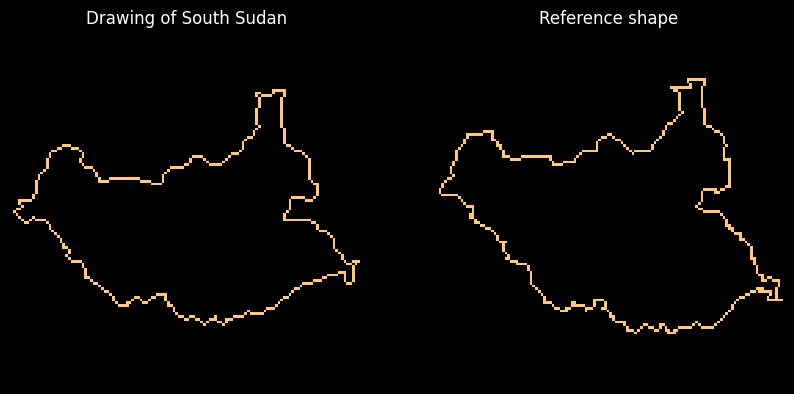

In [7]:
plot_sample(test_data, idx=77)